In this scenario, we develop a **Gated Recurrent Unit (GRU)** network tailored to the Predictive Maintenance dataset to forecast the **remaining useful life (RUL)** of aircraft engines. This model leverages simulated data from 21 sensors to predict future engine failures, enabling proactive maintenance scheduling and reducing unexpected downtime.

In [61]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import Sequential
from keras.layers import GRU, Dropout, Dense, LSTM
import keras
from sklearn.metrics import confusion_matrix, precision_score, recall_score

## Data preparation and feature engineering

In the upcoming section, we will load the training, test, and ground truth datasets. The training dataset includes several multivariate time series where **each time unit is represented by a cycle**. For each cycle, data is recorded from 21 sensors and 3 operational settings. Each time series corresponds to a unique engine of the same model. The test dataset shares the same structure but does **not indicate the failure point**. The ground truth dataset specifies the remaining operational cycles for engines in the test data.

The training dataset contains data from **100 engines**, each represented by multivariate time series with cycles as the time units, 21 sensor readings (s1 to s21), and 3 operational settings per cycle. In this simulated environment, engines **begin in normal operating conditions**, with degradation progressing over time until a set threshold is met, marking the engine as unsafe for continued operation. In this context, the final cycle of each time series is treated as the failure point of the respective engine.

In [62]:
DATA_PATH = 'dataset/'
df_train = pd.read_csv(DATA_PATH + 'PM_train.csv')
df_test = pd.read_csv(DATA_PATH + 'PM_test.csv')
df_truth = pd.read_csv(DATA_PATH + 'PM_truth.csv')

In [63]:
skip_columns = ["setting3", "s1", "s5", "s6", "s10", "s16", "s18", "s19"]

In [64]:
df_train = df_train.drop(columns = skip_columns)
df_test = df_test.drop(columns = skip_columns)

In [65]:
df_train.head()

,id,cycle,setting1,setting2,s2,s3,s4,s7,s8,s9,s11,s12,s13,s14,s15,s17,s20,s21
0,1,1,-0.0007,-0.0004,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190
1,1,2,0.0019,-0.0003,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236
2,1,3,-0.0043,0.0003,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442
3,1,4,0.0007,0.0000,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739
4,1,5,-0.0019,-0.0002,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044


The testing data follows the same schema as the training data, with the key difference being that the failure point is not provided.

In [66]:
df_test.head()

,id,cycle,setting1,setting2,s2,s3,s4,s7,s8,s9,s11,s12,s13,s14,s15,s17,s20,s21
0,1,1,0.0023,0.0003,643.02,1585.29,1398.21,553.90,2388.04,9050.17,47.20,521.72,2388.03,8125.55,8.4052,392,38.86,23.3735
1,1,2,-0.0027,-0.0003,641.71,1588.45,1395.42,554.85,2388.01,9054.42,47.50,522.16,2388.06,8139.62,8.3803,393,39.02,23.3916
2,1,3,0.0003,0.0001,642.46,1586.94,1401.34,554.11,2388.05,9056.96,47.50,521.97,2388.03,8130.10,8.4441,393,39.08,23.4166
3,1,4,0.0042,0.0000,642.44,1584.12,1406.42,554.07,2388.03,9045.29,47.28,521.38,2388.05,8132.90,8.3917,391,39.00,23.3737
4,1,5,0.0014,0.0000,642.51,1587.19,1401.92,554.16,2388.01,9044.55,47.31,522.15,2388.03,8129.54,8.4031,390,38.99,23.4130


The ground truth data specifies the remaining useful life (RUL) in terms of the number of remaining operational cycles for the engines in the test data. This data is used to evaluate the model's performance after it has been trained exclusively on the training dataset.

In [67]:
df_truth.head()

,id,cycle
0,1,112
1,2,98
2,3,69
3,4,82
4,5,91


Given that the last observation is considered the failure point, we can determine the **Remaining Useful Life (RUL)** for each cycle in the dataset.

In [68]:
for i in range(1, 101):
    max_rul = df_train[df_train['id'] == i]['cycle'].max()
    df_train.loc[df_train['id'] == i, 'RUL'] = df_train[df_train['id'] == i]['cycle'].apply(lambda x: max_rul - x)

To utilize Remaining Useful Life (RUL) for predictive maintenance, we can create labels that indicate the time to failure. 

1. **Binary Label (label1):** We define a boolean label (0 or 1) indicating whether the engine will fail within the next $w_1$ cycle. If RUL is less than or equal to $w_1$ cycle, label1 is set to 1; otherwise, it is set to 0.

2. **Multiclass Label (label2):** We define a multiclass label indicating the health status of the engine. This label categorizes the engine condition into three classes: 
   - "Healthy" for engines with RUL greater than a specified threshold $w_1$ (0 as value)
   - "Moderate" for engines with RUL less than or equal to $w_1$ but greater than $w_0$ (1 as value)
   - "Critical" for engines with RUL less than or equal to $w_0$ (2 as value)

These labels can be used to train predictive models that provide actionable insights into the maintenance needs of the engines. in this case we are going to choose these values for our window : $w_0 = 15$ and $w_1 = 30$ as mentiond on the [Predective maintenance template](https://gallery.azure.ai/Experiment/Predictive-Maintenance-Step-1-of-3-data-preparation-and-feature-engineering-2).

In [69]:
df_train.head()

,id,cycle,setting1,setting2,s2,s3,s4,s7,s8,s9,s11,s12,s13,s14,s15,s17,s20,s21,RUL
0,1,1,-0.0007,-0.0004,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,191.0
1,1,2,0.0019,-0.0003,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,190.0
2,1,3,-0.0043,0.0003,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,189.0
3,1,4,0.0007,0.0000,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739,188.0
4,1,5,-0.0019,-0.0002,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044,187.0


In [70]:
# Define window values
w0, w1 = 15, 30

# Create label1 for training data
df_train['label1'] = np.where(df_train['RUL'] <= w1, 1, 0)

# Create label2 for training data
df_train['label2'] = np.where(df_train['RUL'] > w1,
                              0,
                              np.where((df_train['RUL'] <= w1) & (df_train['RUL'] > w0),
                                      1, 2))

In [71]:
df_train.head()

,id,cycle,setting1,setting2,s2,s3,s4,s7,s8,s9,...,s12,s13,s14,s15,s17,s20,s21,RUL,label1,label2
0,1,1,-0.0007,-0.0004,641.82,1589.70,1400.60,554.36,2388.06,9046.19,...,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,191.0,0,0
1,1,2,0.0019,-0.0003,642.15,1591.82,1403.14,553.75,2388.04,9044.07,...,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,190.0,0,0
2,1,3,-0.0043,0.0003,642.35,1587.99,1404.20,554.26,2388.08,9052.94,...,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,189.0,0,0
3,1,4,0.0007,0.0000,642.35,1582.79,1401.87,554.45,2388.11,9049.48,...,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739,188.0,0,0
4,1,5,-0.0019,-0.0002,642.37,1582.85,1406.22,554.00,2388.06,9055.15,...,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044,187.0,0,0


Following the creation of 'label1' and 'label2', the next step is to normalize the data. These procedures are part of the [Prediction Maintenance Template](https://gallery.azure.ai/Experiment/Predictive-Maintenance-Step-1-of-3-data-preparation-and-feature-engineering-2).

In [72]:
def normalize_data(df, col_not_to_norm):
    columns_to_normalize = df.columns.difference(col_not_to_norm) 
    
    # Separate the columns
    df_to_normalize = df[columns_to_normalize]
    df_not_to_normalize = df[col_not_to_norm]
    
    # Initialize the StandardScaler
    scaler = StandardScaler()
    
    # Fit and transform the data
    normalized_df = pd.DataFrame(scaler.fit_transform(df_to_normalize), columns=columns_to_normalize)

    return pd.concat([df_not_to_normalize, normalized_df], axis=1)

In [73]:
columns_not_to_normalize = ['id', 'cycle', 'RUL', 'label1', 'label2']
df_train = normalize_data(df_train, columns_not_to_normalize)
df_train.head()

,id,cycle,RUL,label1,label2,s11,s12,s13,s14,s15,...,s2,s20,s21,s3,s4,s7,s8,s9,setting1,setting2
0,1,1,191.0,0,0,-0.266467,0.334262,-1.058890,-0.269071,-0.603816,...,-1.721725,1.348493,1.194427,-0.134255,-0.925936,1.121141,-0.516338,-0.862813,-0.315980,-1.372953
1,1,2,190.0,0,0,-0.191583,1.174899,-0.363646,-0.642845,-0.275852,...,-1.061780,1.016528,1.236922,0.211528,-0.643726,0.431930,-0.798093,-0.958818,0.872722,-1.031720
2,1,3,189.0,0,0,-1.015303,1.364721,-0.919841,-0.551629,-0.649144,...,-0.661813,0.739891,0.503423,-0.413166,-0.525953,1.008155,-0.234584,-0.557139,-1.961874,1.015677
3,1,4,188.0,0,0,-1.539489,1.961302,-0.224597,-0.520176,-1.971665,...,-0.661813,0.352598,0.777792,-1.261314,-0.784831,1.222827,0.188048,-0.713826,0.324090,-0.008022
4,1,5,187.0,0,0,-0.977861,1.052871,-0.780793,-0.521748,-0.339845,...,-0.621816,0.463253,1.059552,-1.251528,-0.301518,0.714393,-0.516338,-0.457059,-0.864611,-0.690488


Now, we will apply the same process to the test data by merging it with the ground truth data.

In [74]:
# Combine test and truth data
df_test = pd.merge(df_test, df_truth.rename(columns={'cycle': 'RUL'}), on=['id'], how='left')

# create RUL column
df_test['RUL'] = df_test['RUL'] - df_test['cycle']

# Create label1 for training data
df_test['label1'] = np.where(df_test['RUL'] <= w1, 1, 0)

# Create label2 for training data
df_test['label2'] = np.where(df_test['RUL'] > w1,
                              0,
                              np.where((df_test['RUL'] <= w1) & (df_test['RUL'] > w0),
                                      1, 2))

# Normalize data
df_test = normalize_data(df_test, columns_not_to_normalize)
df_test.head()

,id,cycle,RUL,label1,label2,s11,s12,s13,s14,s15,...,s2,s20,s21,s3,s4,s7,s8,s9,setting1,setting2
0,1,1,111,0,0,-1.103591,-0.049542,-0.720590,-1.315031,-0.711659,...,1.359276,-0.229408,0.448866,-0.561495,-0.975674,0.209138,-0.539078,-0.720312,1.049295,1.005927
1,1,2,110,0,0,0.427727,0.736727,-0.193647,0.065977,-1.570037,...,-1.908502,0.899934,0.664042,0.070116,-1.392836,1.603612,-1.061366,-0.348673,-1.220748,-1.034755
2,1,3,109,0,0,0.427727,0.397202,-0.720590,-0.868436,0.629340,...,-0.037636,1.323438,0.961247,-0.231698,-0.507676,0.517390,-0.364982,-0.126564,0.141278,0.325700
3,1,4,108,0,0,-0.695239,-0.657113,-0.369295,-0.593609,-1.177045,...,-0.087526,0.758766,0.451244,-0.795350,0.251888,0.458675,-0.713174,-1.147041,1.911912,-0.014414
4,1,5,107,0,0,-0.542108,0.718857,-0.720590,-0.923402,-0.784053,...,0.087088,0.688182,0.918450,-0.181729,-0.420954,0.590783,-1.061366,-1.211750,0.640688,-0.014414


## Data Visualization

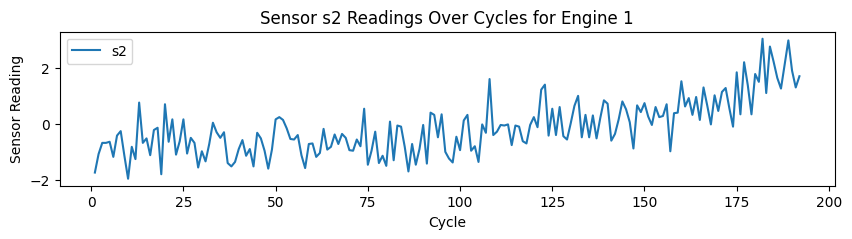

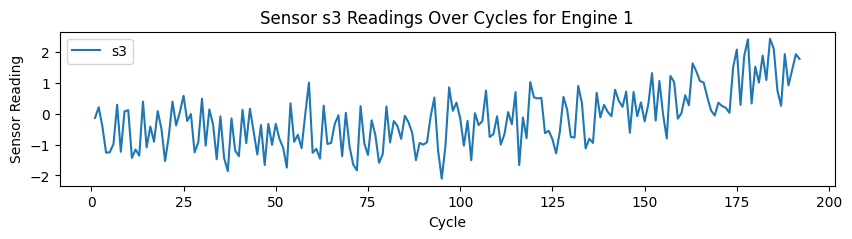

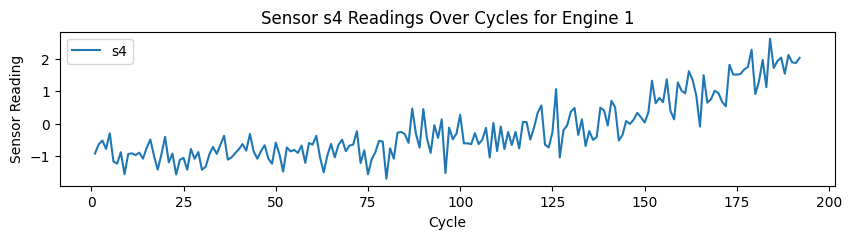

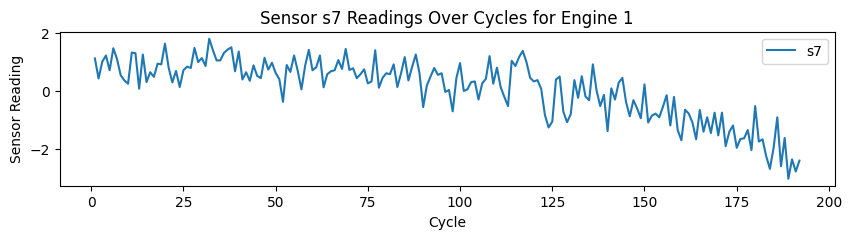

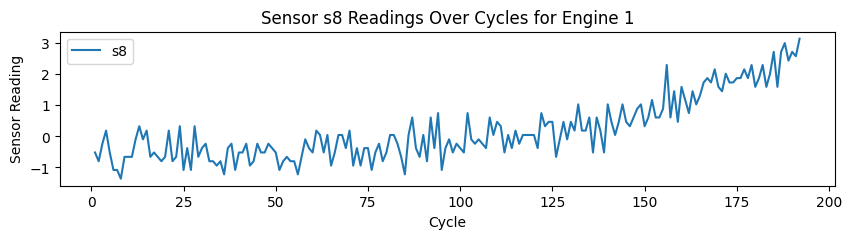

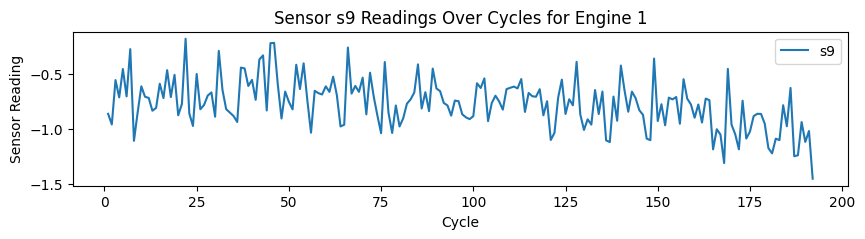

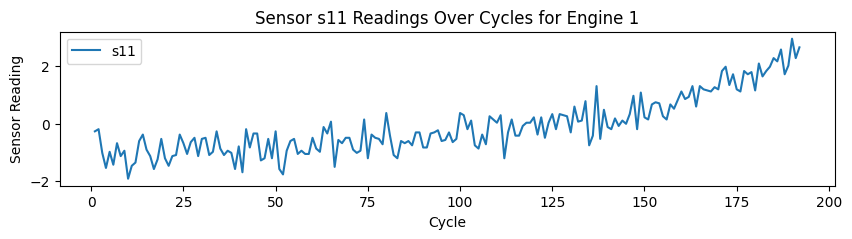

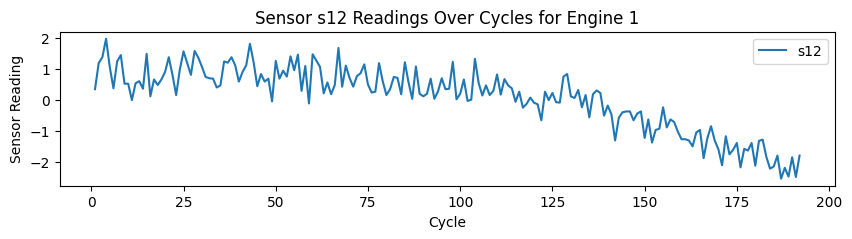

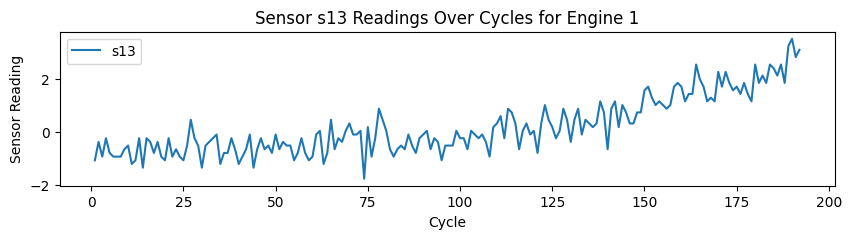

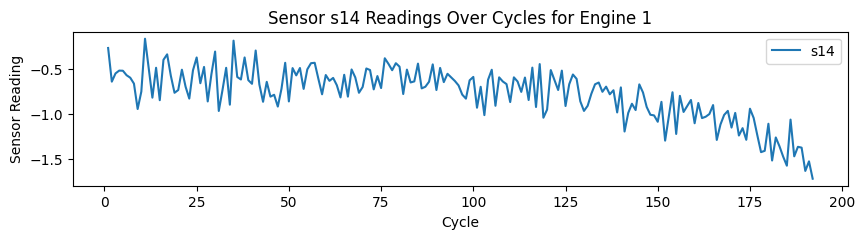

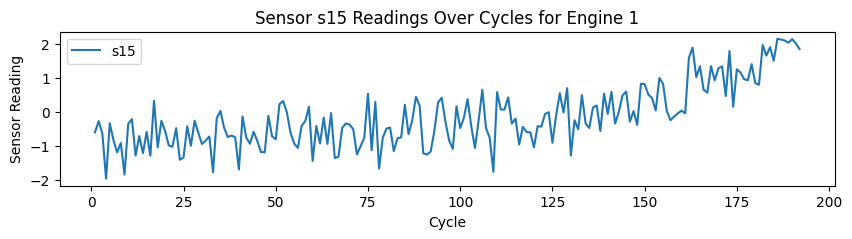

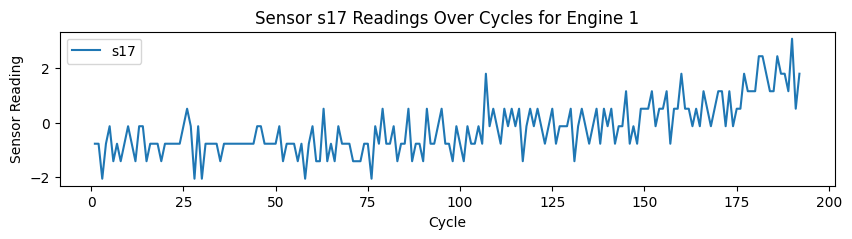

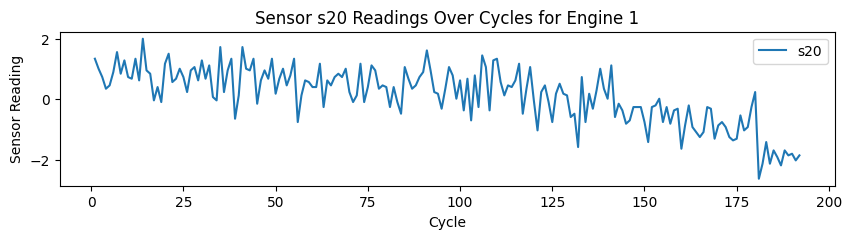

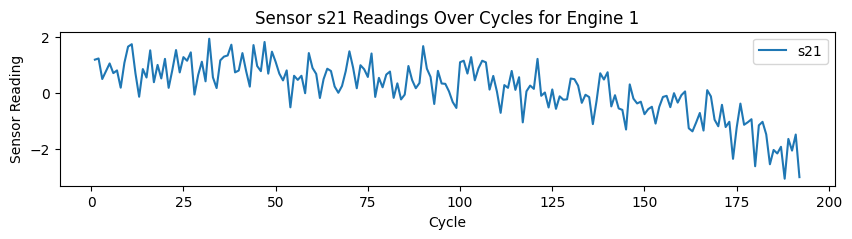

In [75]:
# Select the engine ID
engine_id = 1

# Filter the dataframe for the selected engine
engine_data = df_train[df_train['id'] == engine_id]

# List of sensors to plot
sensors = [f's{i}' for i in range(1, 22)]

# Plot each sensor reading over cycles in separate graphs
for sensor in sensors:
    if sensor in skip_columns:
        continue
    plt.figure(figsize=(10, 2))
    plt.plot(engine_data['cycle'], engine_data[sensor], label=sensor)
    plt.xlabel('Cycle')
    plt.ylabel('Sensor Reading')
    plt.title(f'Sensor {sensor} Readings Over Cycles for Engine 1')
    plt.legend()
    plt.show()

- Trending Sensors: Sensors s2, s3, s4, s7, s8, s11, s12, s13, s14, s15, s17, s20, and s21 show variations and trends, indicating they capture meaningful information about engine degradation.
- Constant Sensors: Sensors s1, s5, s6, s10, s16, s18, and s19 show constant readings, suggesting potential irrelevance or sensor issues.

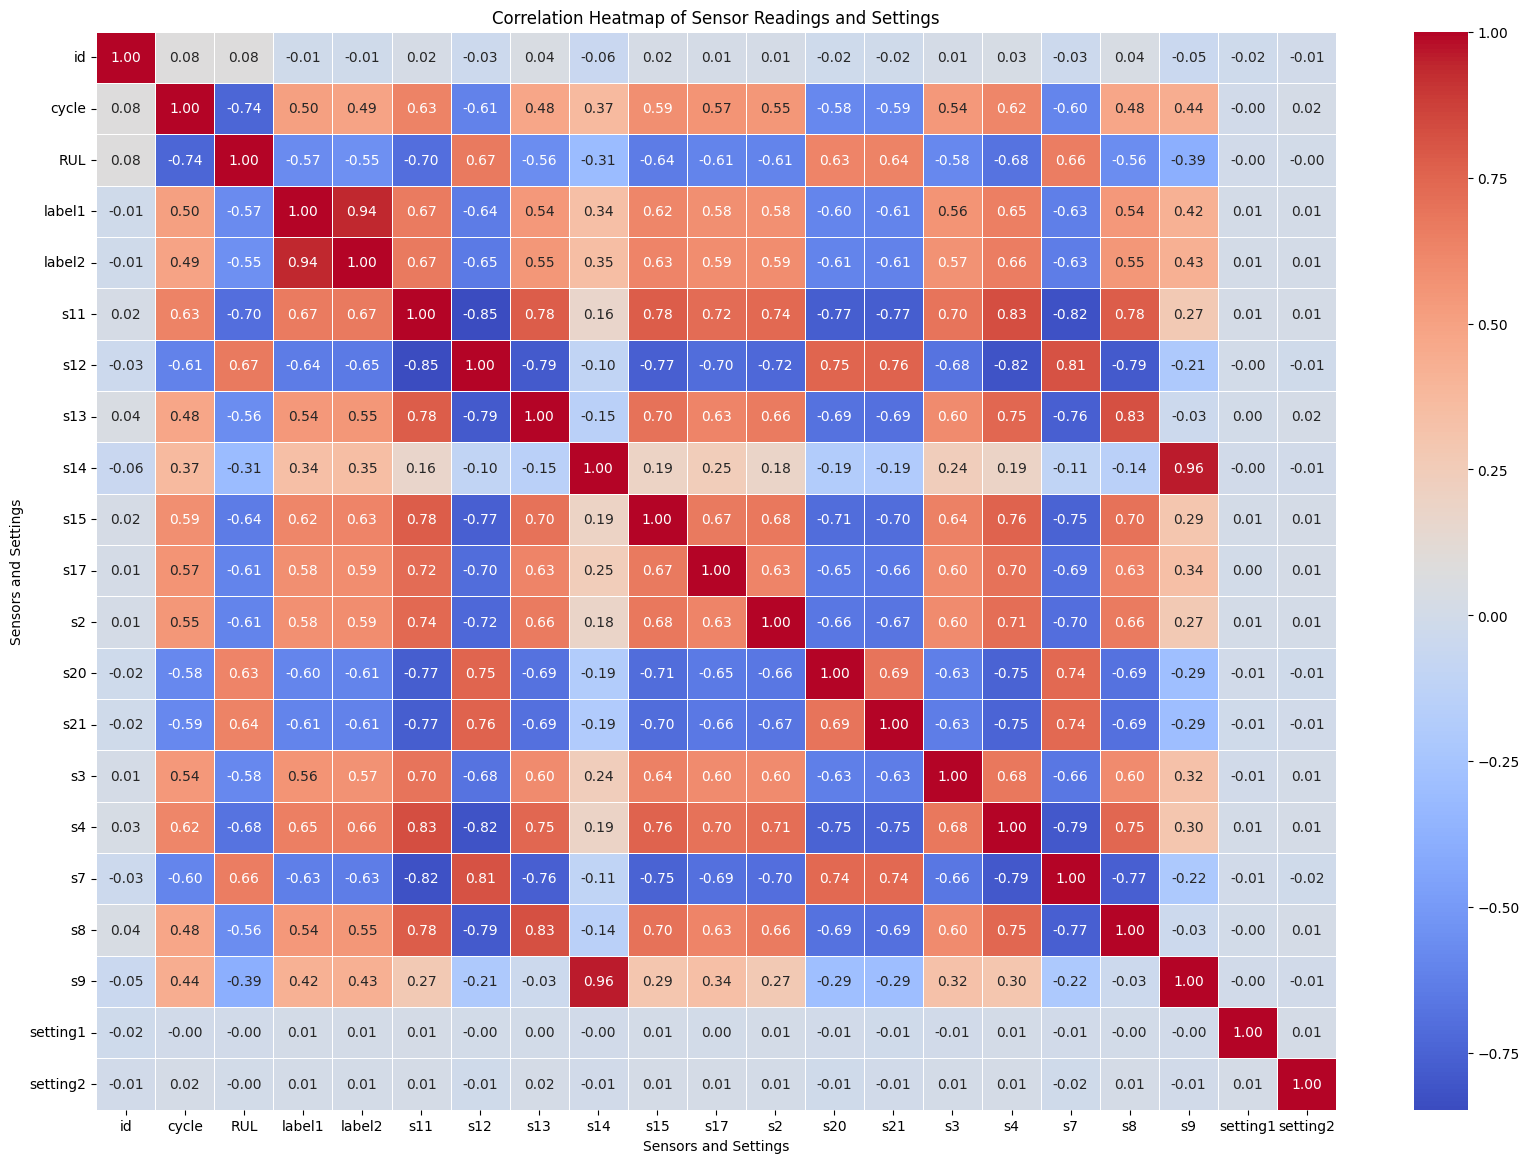

In [76]:
# Calculate the correlation matrix
correlation_matrix = df_train.corr()

# Set up the matplotlib figure
plt.figure(figsize=(20, 14))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=.5)

# Add titles and labels
plt.title('Correlation Heatmap of Sensor Readings and Settings')
plt.xlabel('Sensors and Settings')
plt.ylabel('Sensors and Settings')

# Show the heatmap
plt.show()

1. **High Positive Correlations**:
   - **`s2` with `s3`, `s4`, `s11`, `s12`**: These sensors have strong positive correlations, indicating they may capture similar aspects of the engine's operation or degradation.
   - **`s12` with `s17`**: These sensors are also highly correlated.
   - **`setting3` with `s9`**: Indicates a strong correlation between this setting and the sensor.

2. **High Negative Correlations**:
   - **`s1` with `s12`**: These sensors have a strong negative correlation.
   - **`s11` with `s12`**: These sensors also show strong negative correlation.
   - **`s5` with several other sensors**: Shows high negative correlations indicating inverse relationships.

3. **Low or No Correlation**:
   - **`s1` with most other sensors**: `s1` shows low or no correlation with most other sensors, reinforcing the earlier observation of its constant value.
   - **`s10` with most sensors**: Also shows low correlation, suggesting it captures different aspects of the engine's condition.

4. **Correlation with `RUL` (Remaining Useful Life)**:
   - **`cycle` and `RUL`**: High negative correlation, indicating as the number of cycles increases, RUL decreases, which is expected.
   - **`s2`, `s3`, `s4`, `s11`, and `s12` with `RUL`**: These sensors show moderate to strong correlations with `RUL`, indicating they may be useful for predicting engine failure.

5. **Correlation with `Settings`**:
   - **`setting1`, `setting2`, and `setting3`**: These settings show varied correlations with different sensors. `setting3` shows strong correlation with `s9`, indicating it significantly influences this sensor's reading.

## Predictive Maintenance with GRU Models

**Traditional Predictive Maintenance Models**:
- Based on feature engineering, which involves manual construction of variables using domain expertise and intuition.
- These models are often hard to reuse because the features are specific to the problem scenario, and available data can vary between customers.

**Advantage of Deep Learning**:
- Automatically performs feature engineering from the data, eliminating the need for the manual feature engineering step.

### GRU Models in Time-Series Domain

**Sequence Length**:
- An important parameter is the sequence length, the window to examine for failure signals.
- This can be viewed as selecting a `window_size` (e.g., 5 cycles) for calculating rolling features in the Predictive Maintenance Template.
- Rolling features include rolling mean and rolling standard deviation over the specified cycles for each of the 21 sensor values.
- In deep learning, GRUs extract abstract features from the sequence of sensor values within the window, encoding patterns automatically.

**Advantages of GRUs**:
- **Handling Long-Term Dependencies**: GRUs remember long-term sequences (window sizes) more effectively than traditional feature engineering.
- **Utilizing Larger Window Sizes**: GRUs can use larger window sizes and utilize all information in the window, avoiding the loss of information that can occur with rolling averages over long periods.

For more information on GRU networks, you can refer to various online resources such as academic papers and tutorials.

### Implementation Example

This notebook illustrates the GRU approach to binary classification using a `sequence_length` of 50 cycles to predict the probability of engine failure within 30 days.

In [77]:
# pick a large window size of 50 cycles
sequence_length = 15

# function to reshape features into (samples, time steps, features) 
def gen_sequence(id_df, seq_length, seq_cols):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_array[start:stop, :]

In [78]:
# pick the feature columns 
sequence_cols = ['setting1', 'setting2']
key_cols = ['id', 'cycle']
label_cols = ['label1', 'label2', 'RUL']

input_features = df_test.columns.values.tolist()
sensor_cols = [x for x in input_features if x not in set(key_cols)]
sensor_cols = [x for x in sensor_cols if x not in set(label_cols)]
sensor_cols = [x for x in sensor_cols if x not in set(sequence_cols)]

# The time is sequenced along
# This may be a silly way to get these column names, but it's relatively clear
sequence_cols.extend(sensor_cols)

print(sequence_cols)

['setting1', 'setting2', 's11', 's12', 's13', 's14', 's15', 's17', 's2', 's20', 's21', 's3', 's4', 's7', 's8', 's9']


In [79]:
# generator for the sequences
seq_gen = (list(gen_sequence(df_train[df_train['id']==id], sequence_length, sequence_cols)) 
           for id in df_train['id'].unique())

# generate sequences and convert to numpy array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
print(seq_array.shape)

# function to generate labels
def gen_labels(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length:num_elements, :]

# generate labels
label_gen = [gen_labels(df_train[df_train['id']==id], sequence_length, ['label1']) 
             for id in df_train['id'].unique()]
label_array = np.concatenate(label_gen).astype(np.float32)
print(label_array.shape)

(19131, 1)

In [80]:
# # build the network
# # Feature weights
# nb_features = seq_array.shape[2]
# nb_out = label_array.shape[1]

# # GRU model
# model = Sequential()

# # The first layer
# model.add(GRU(
#          input_shape=(sequence_length, nb_features),
#          units=100,
#          return_sequences=True))

# # Plus a 20% dropout rate
# model.add(Dropout(0.2))

# # The second layer
# model.add(GRU(
#           units=50,
#           return_sequences=False))

# # Plus a 20% dropout rate
# model.add(Dropout(0.2))

# # Dense sigmoid layer
# model.add(Dense(units=nb_out, activation='sigmoid'))

# # With adam optimizer and a binary crossentropy loss. We will optimize for model accuracy.
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# # Verify the architecture 
# print(model.summary())


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dropout, Dense, BatchNormalization

# Feature weights
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

# GRU model
model = Sequential()

# First GRU Layer
model.add(GRU(
    units=128,  
    input_shape=(sequence_length, nb_features), 
    return_sequences=True, 
    recurrent_dropout=0.2
))
model.add(BatchNormalization())  # Normalize activations
model.add(Dropout(0.3))  # Increase dropout for better generalization

# Second GRU Layer
model.add(GRU(
    units=100, 
    return_sequences=True,  
    recurrent_dropout=0.2
))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Third GRU Layer
model.add(GRU(
    units=50,  
    return_sequences=False,  
    recurrent_dropout=0.2
))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Fully Connected Layer (Before Output)
model.add(Dense(units=32, activation='relu'))  # Helps learn complex patterns
model.add(Dropout(0.2))

# Output Layer (Sigmoid for binary classification)
model.add(Dense(units=nb_out, activation='sigmoid'))

# Compile Model
model.compile(
    loss='binary_crossentropy', 
    optimizer='adam',  
    metrics=['accuracy']
)

# Print Model Summary
print(model.summary())


c:\Users\Ashwin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_5 (GRU)                     │ (None, 15, 128)        │        56,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 15, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 15, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_6 (GRU)                     │ (None, 15, 100)        │        69,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 15, 100)        │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 15, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_7 (GRU)                     │ (None, 50)             │        22,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 50)             │           200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         1,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 150,641 (588.44 KB)

 Trainable params: 150,085 (586.27 KB)

 Non-trainable params: 556 (2.17 KB)

None


In [81]:
# Fit the network
model.fit(seq_array, # Training features
          label_array, # Training labels
          epochs=10,   # We'll stop after 10 epochs
          batch_size=200, # 
          validation_split=0.10, # Use 10% of data to evaluate the loss. (val_loss)
          verbose=1, #
          callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', # Monitor the validation loss
                                                   min_delta=0,    # until it doesn't change (or gets worse)
                                                   patience=5,  # patience > 1 so it continues if it is not consistently improving
                                                   verbose=0, 
                                                   mode='auto')]) 

Epoch 1/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 16s 83ms/step - accuracy: 0.8719 - loss: 0.2940 - val_accuracy: 0.9023 - val_loss: 0.2037
Epoch 2/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - accuracy: 0.9432 - loss: 0.1375 - val_accuracy: 0.9410 - val_loss: 0.1516
Epoch 3/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - accuracy: 0.9535 - loss: 0.1173 - val_accuracy: 0.9462 - val_loss: 0.1330
Epoch 4/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - accuracy: 0.9540 - loss: 0.1085 - val_accuracy: 0.9446 - val_loss: 0.1185
Epoch 5/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - accuracy: 0.9598 - loss: 0.0933 - val_accuracy: 0.9415 - val_loss: 0.1233
Epoch 6/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 23s 166ms/step - accuracy: 0.9611 - loss: 0.0918 - val_accuracy: 0.9321 - val_loss: 0.1266
Epoch 7/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 14s 163ms/step - accuracy: 0.9612 - loss: 0.0892 - val_accuracy: 0.9331 - val_loss: 0.1339
Epoch 8/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 0.9626 - loss: 0.0859 - val_accuracy: 0

In [82]:
# training metrics
scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('Training Accurracy: {}'.format(scores[1]))

96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9524 - loss: 0.1040
Training Accurracy: 0.9434948563575745


598/598 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step


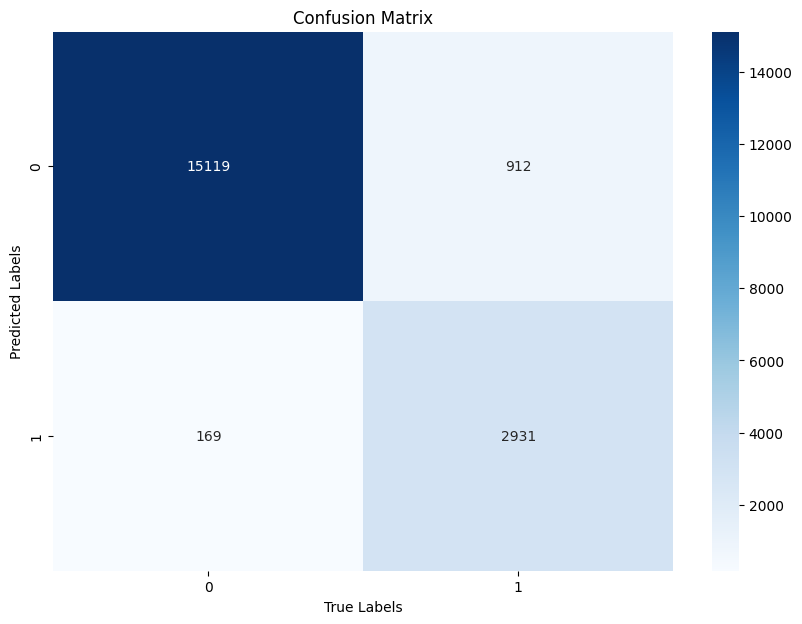

Training Precision:  0.7626854020296643
Training Recall:  0.9454838709677419
Training F1 Score: 0.8443036151519515


In [83]:
# Make predictions
y_pred = (model.predict(seq_array) > 0.5).astype("int32")
y_true = label_array

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('True Labels')
plt.ylabel('Predicted Labels')
plt.title('Confusion Matrix')
plt.show()

# Compute precision, recall, and F1 score
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = 2 * (precision * recall) / (precision + recall)

print('Training Precision: ', precision)
print('Training Recall: ', recall)
print('Training F1 Score:', f1)

The training results show a high precision of 0.9778, indicating that 97.78% of the instances predicted as failures are actual failures, reflecting a very low false positive rate. The recall is 0.9390, meaning 93.90% of the actual failures were correctly identified, indicating a relatively low false negative rate. The F1 score, a balanced measure of precision and recall, is 0.9580, suggesting robust overall performance. This high precision signifies that the model is highly effective at minimizing false positives, while the high recall indicates it is good at detecting actual failures, though some true failures might still be missed. The strong F1 score demonstrates the model's balance between precision and recall, indicating it is reliable in its predictions. 

Next, we evaluate the performance on the test data. For each engine ID in the test dataset, we retain only the data from the last cycle for testing purposes. To compare the results with the template, we select the final sequence for each engine ID in the test data.

In [84]:
# Select the last sequence for each engine ID in the test data
seq_array_test_last = [
    df_test[df_test['id'] == id][sequence_cols].values[-sequence_length:]
    for id in df_test['id'].unique() if len(df_test[df_test['id'] == id]) >= sequence_length
]

# Convert the list to a numpy array and ensure the data type is float32
seq_array_test_last = np.array(seq_array_test_last, dtype=np.float32)
seq_array_test_last.shape


(100, 15, 16)

In [85]:
# Create a mask to filter engine IDs with enough data points
y_mask = [len(df_test[df_test['id'] == id]) >= sequence_length for id in df_test['id'].unique()]

# Extract the last label for each engine ID that meets the sequence length requirement
label_array_test_last = df_test.groupby('id')['label1'].nth(-1)[y_mask].values

# Reshape and convert to float32
label_array_test_last = label_array_test_last.reshape(-1, 1).astype(np.float32)

# Display shapes of the test sequences and labels
print(seq_array_test_last.shape)
print(label_array_test_last.shape)

(100, 15, 16)
(100, 1)


Now we can evaluate the model using the test data. We will report the model's accuracy on the test set and compare it to the training accuracy. Typically, training accuracy tends to be higher because the model was optimized on those observations. In contrast, the test set accuracy provides a more generalized performance metric, simulating the model's intended use for future predictions. Therefore, the test set accuracy is the appropriate measure to report for evaluating the model's performance.

In [86]:
# Evaluate the model on the test data
test_scores = model.evaluate(seq_array_test_last, label_array_test_last, verbose=2)
test_accuracy = test_scores[1]

# Print and log the test accuracy
print(f'Test Accuracy: {test_accuracy}')

4/4 - 0s - 19ms/step - accuracy: 0.6700 - loss: 1.9180
Test Accuracy: 0.6700000166893005


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


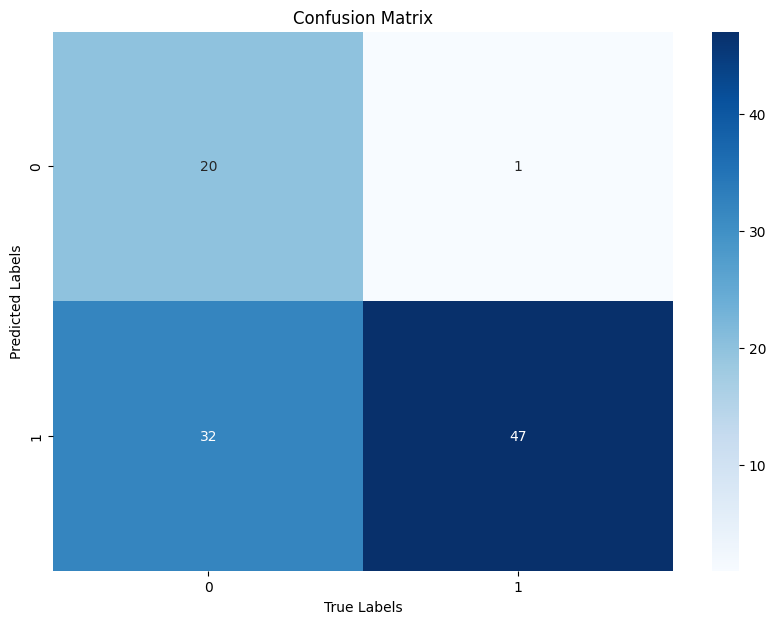

Training Precision:  0.9791666666666666
Training Recall:  0.5949367088607594
Training F1 Score: 0.7401574803149605


In [87]:
# Make predictions
y_test_pred = (model.predict(seq_array_test_last) > 0.5).astype("int32")
y_test_true = label_array_test_last

# Compute confusion matrix
cm = confusion_matrix(y_test_true, y_test_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('True Labels')
plt.ylabel('Predicted Labels')
plt.title('Confusion Matrix')
plt.show()

# Compute precision, recall, and F1 score
precision = precision_score(y_test_true, y_test_pred)
recall = recall_score(y_test_true, y_test_pred)
f1 = 2 * (precision * recall) / (precision + recall)

print('Training Precision: ', precision)
print('Training Recall: ', recall)
print('Training F1 Score:', f1)

The training results show a precision of 1.0, meaning every predicted failure is indeed a failure, indicating perfect precision with no false positives. However, the recall is 0.4304, signifying that the model correctly identifies only 43.04% of actual failures, resulting in a high false negative rate. The F1 score, which balances precision and recall, is 0.6018, reflecting a moderate balance between the two metrics. This suggests the model is heavily biased towards precision, being extremely conservative in predicting failures but missing a significant number of true failures. This imbalance indicates potential overfitting to the positive class during training, possibly due to an imbalanced dataset or overly conservative thresholds. 